In [ ]:
#  Install Libraries
!pip install tensorflow keras pandas numpy matplotlib scikit-learn pillow seaborn




[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#  Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

In [ ]:
#  Data Configuration
dataset_path = "dataset"

classes = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
label_map = {name: i for i, name in enumerate(classes)}



In [ ]:
# Load and Preprocess Images

images = []
labels = []

for folder in classes:
    folder_path = os.path.join(dataset_path, folder)
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(label_map[folder])

images = np.array(images)
labels = np.array(labels)
images = images.astype("float32") / 255.0


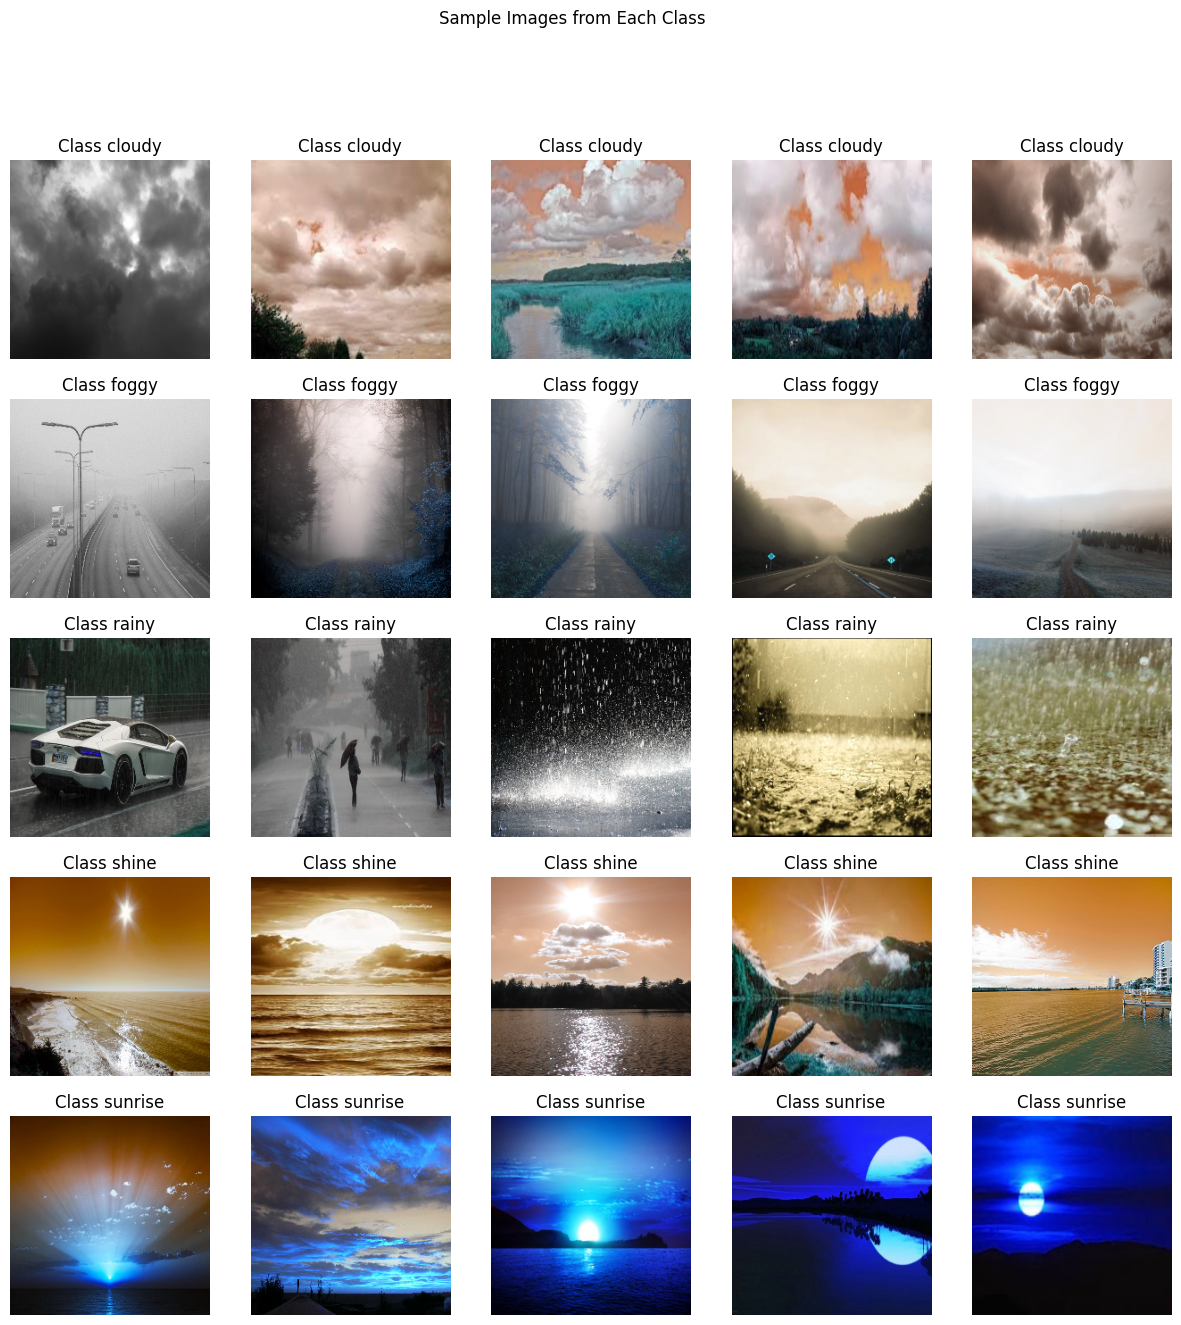

In [ ]:
# Visualize Images

plt.figure(figsize = (15,15))
for i, subfolder in enumerate(classes):
    class_indices = np.where(labels == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(classes), 5, i*5 + j +1)
        plt.imshow(images[class_indices[j]])
        plt.title(f"Class {subfolder}")
        plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

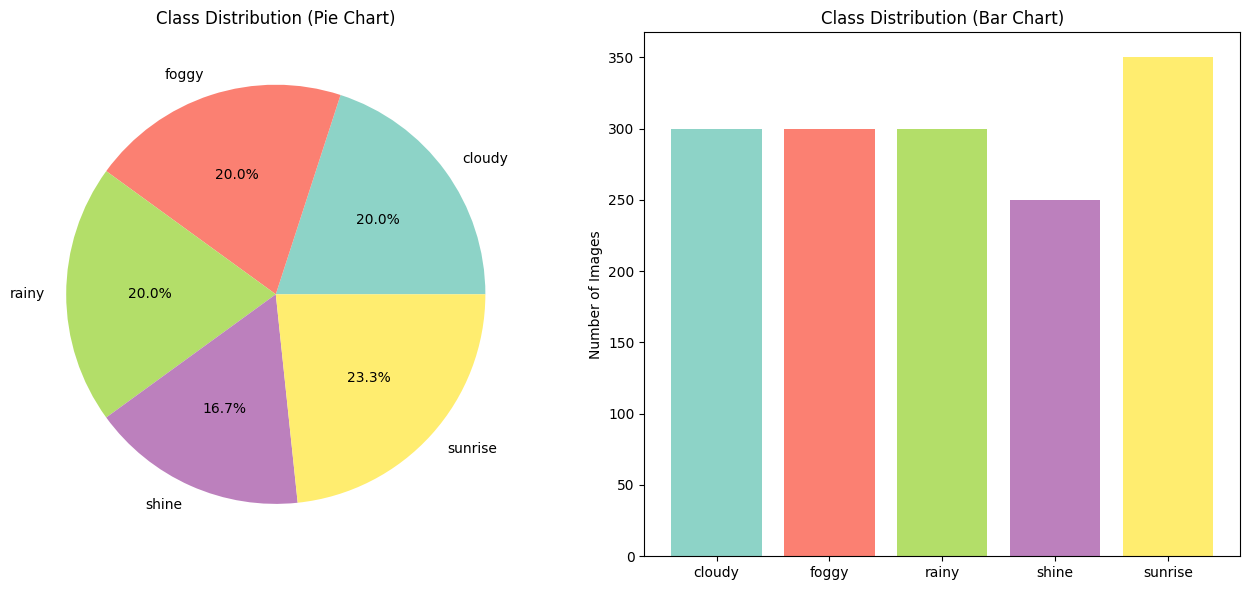

In [ ]:
#  Class Distribution
class_counts = [np.sum(labels == label_map[c]) for c in classes]

plt.figure(figsize=(13,6))

# PIE
plt.subplot(1,2,1)
plt.pie(class_counts, labels=classes, autopct='%1.1f%%',
        colors=plt.cm.Set3(np.linspace(0,1,len(classes))))
plt.title("Class Distribution (Pie Chart)")

# BAR
plt.subplot(1,2,2)
plt.bar(classes, class_counts, color=plt.cm.Set3(np.linspace(0,1,len(classes))))
plt.title("Class Distribution (Bar Chart)")
plt.ylabel("Number of Images")

plt.tight_layout()
plt.show()


In [10]:
# Shuffle images and labels together
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]


In [ ]:
# data augmentation and split
datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow(
    images, labels,
    subset='training',
    batch_size=32
)

val_gen = datagen.flow(
    images, labels,
    subset='validation',
    batch_size=32
)


In [12]:
# Preprocessing

dataset_path = "dataset"  

classes = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.6,1.4]
)


test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
#  CNN Model
model = Sequential([
    #  1st Conv Block
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2),

    #  2nd Conv Block
    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    # 3rd Conv Block
    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),
    
     # Flatten and Dense layers
    Flatten(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    Dense(5, activation="softmax")  # Output layer for 5 classes
])

# Compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


c:\Users\sushm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,786,821 (98.37 MB)

 Trainable params: 25,785,861 (98.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3)
]


In [ ]:
# Train the Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6225 - loss: 1.2844 - val_accuracy: 0.1933 - val_loss: 12.3619 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7417 - loss: 0.7730 - val_accuracy: 0.1933 - val_loss: 5.2627 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7725 - loss: 0.6575 - val_accuracy: 0.1933 - val_loss: 7.0096 - learning_rate: 0.0010
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7700 - loss: 0.6679 - val_accuracy: 0.2967 - val_loss: 3.2004 - learning_rate: 0.0010
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7175 - loss: 0.8410 - val_accuracy: 0.3200 - val_loss: 2.3711 - learning_rate: 0.0010
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7817 - loss: 0.5990 - val_accuracy: 0.3567 - val_loss: 2.3852 - learning_rate: 0.0010
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7958 - loss: 0.5505 - val_accuracy:

In [16]:
# Ensure the validation generator does NOT shuffle
val_gen = datagen.flow(
    images, labels,
    subset='validation',
    batch_size=32,
    shuffle=False
)




10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step
              precision    recall  f1-score   support

           0       0.89      0.70      0.79        71
           1       0.53      0.82      0.65        51
           2       0.83      0.84      0.84        58
           3       0.95      0.74      0.83        54
           4       0.95      0.92      0.94        66

    accuracy                           0.81       300
   macro avg       0.83      0.81      0.81       300
weighted avg       0.84      0.81      0.81       300



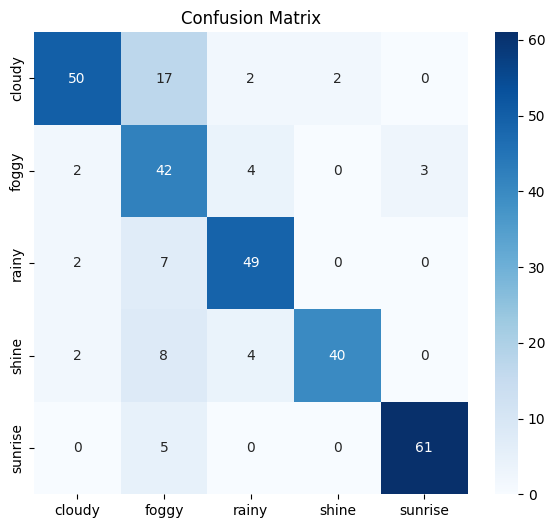

In [ ]:
#  Model Evaluation

# Predict validation set
pred = model.predict(val_gen)
pred_classes = np.argmax(pred, axis=1)
true_classes = labels[val_gen.index_array] 

# Classification report
print(classification_report(true_classes, pred_classes))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes,
            yticklabels=classes,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


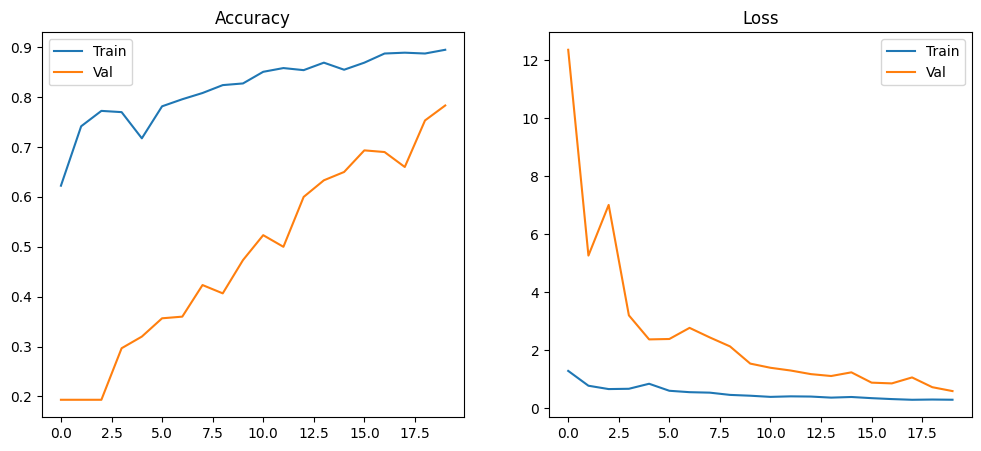

In [ ]:
# Accuracy & Loss plots

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Train", "Val"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["Train", "Val"])

plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step


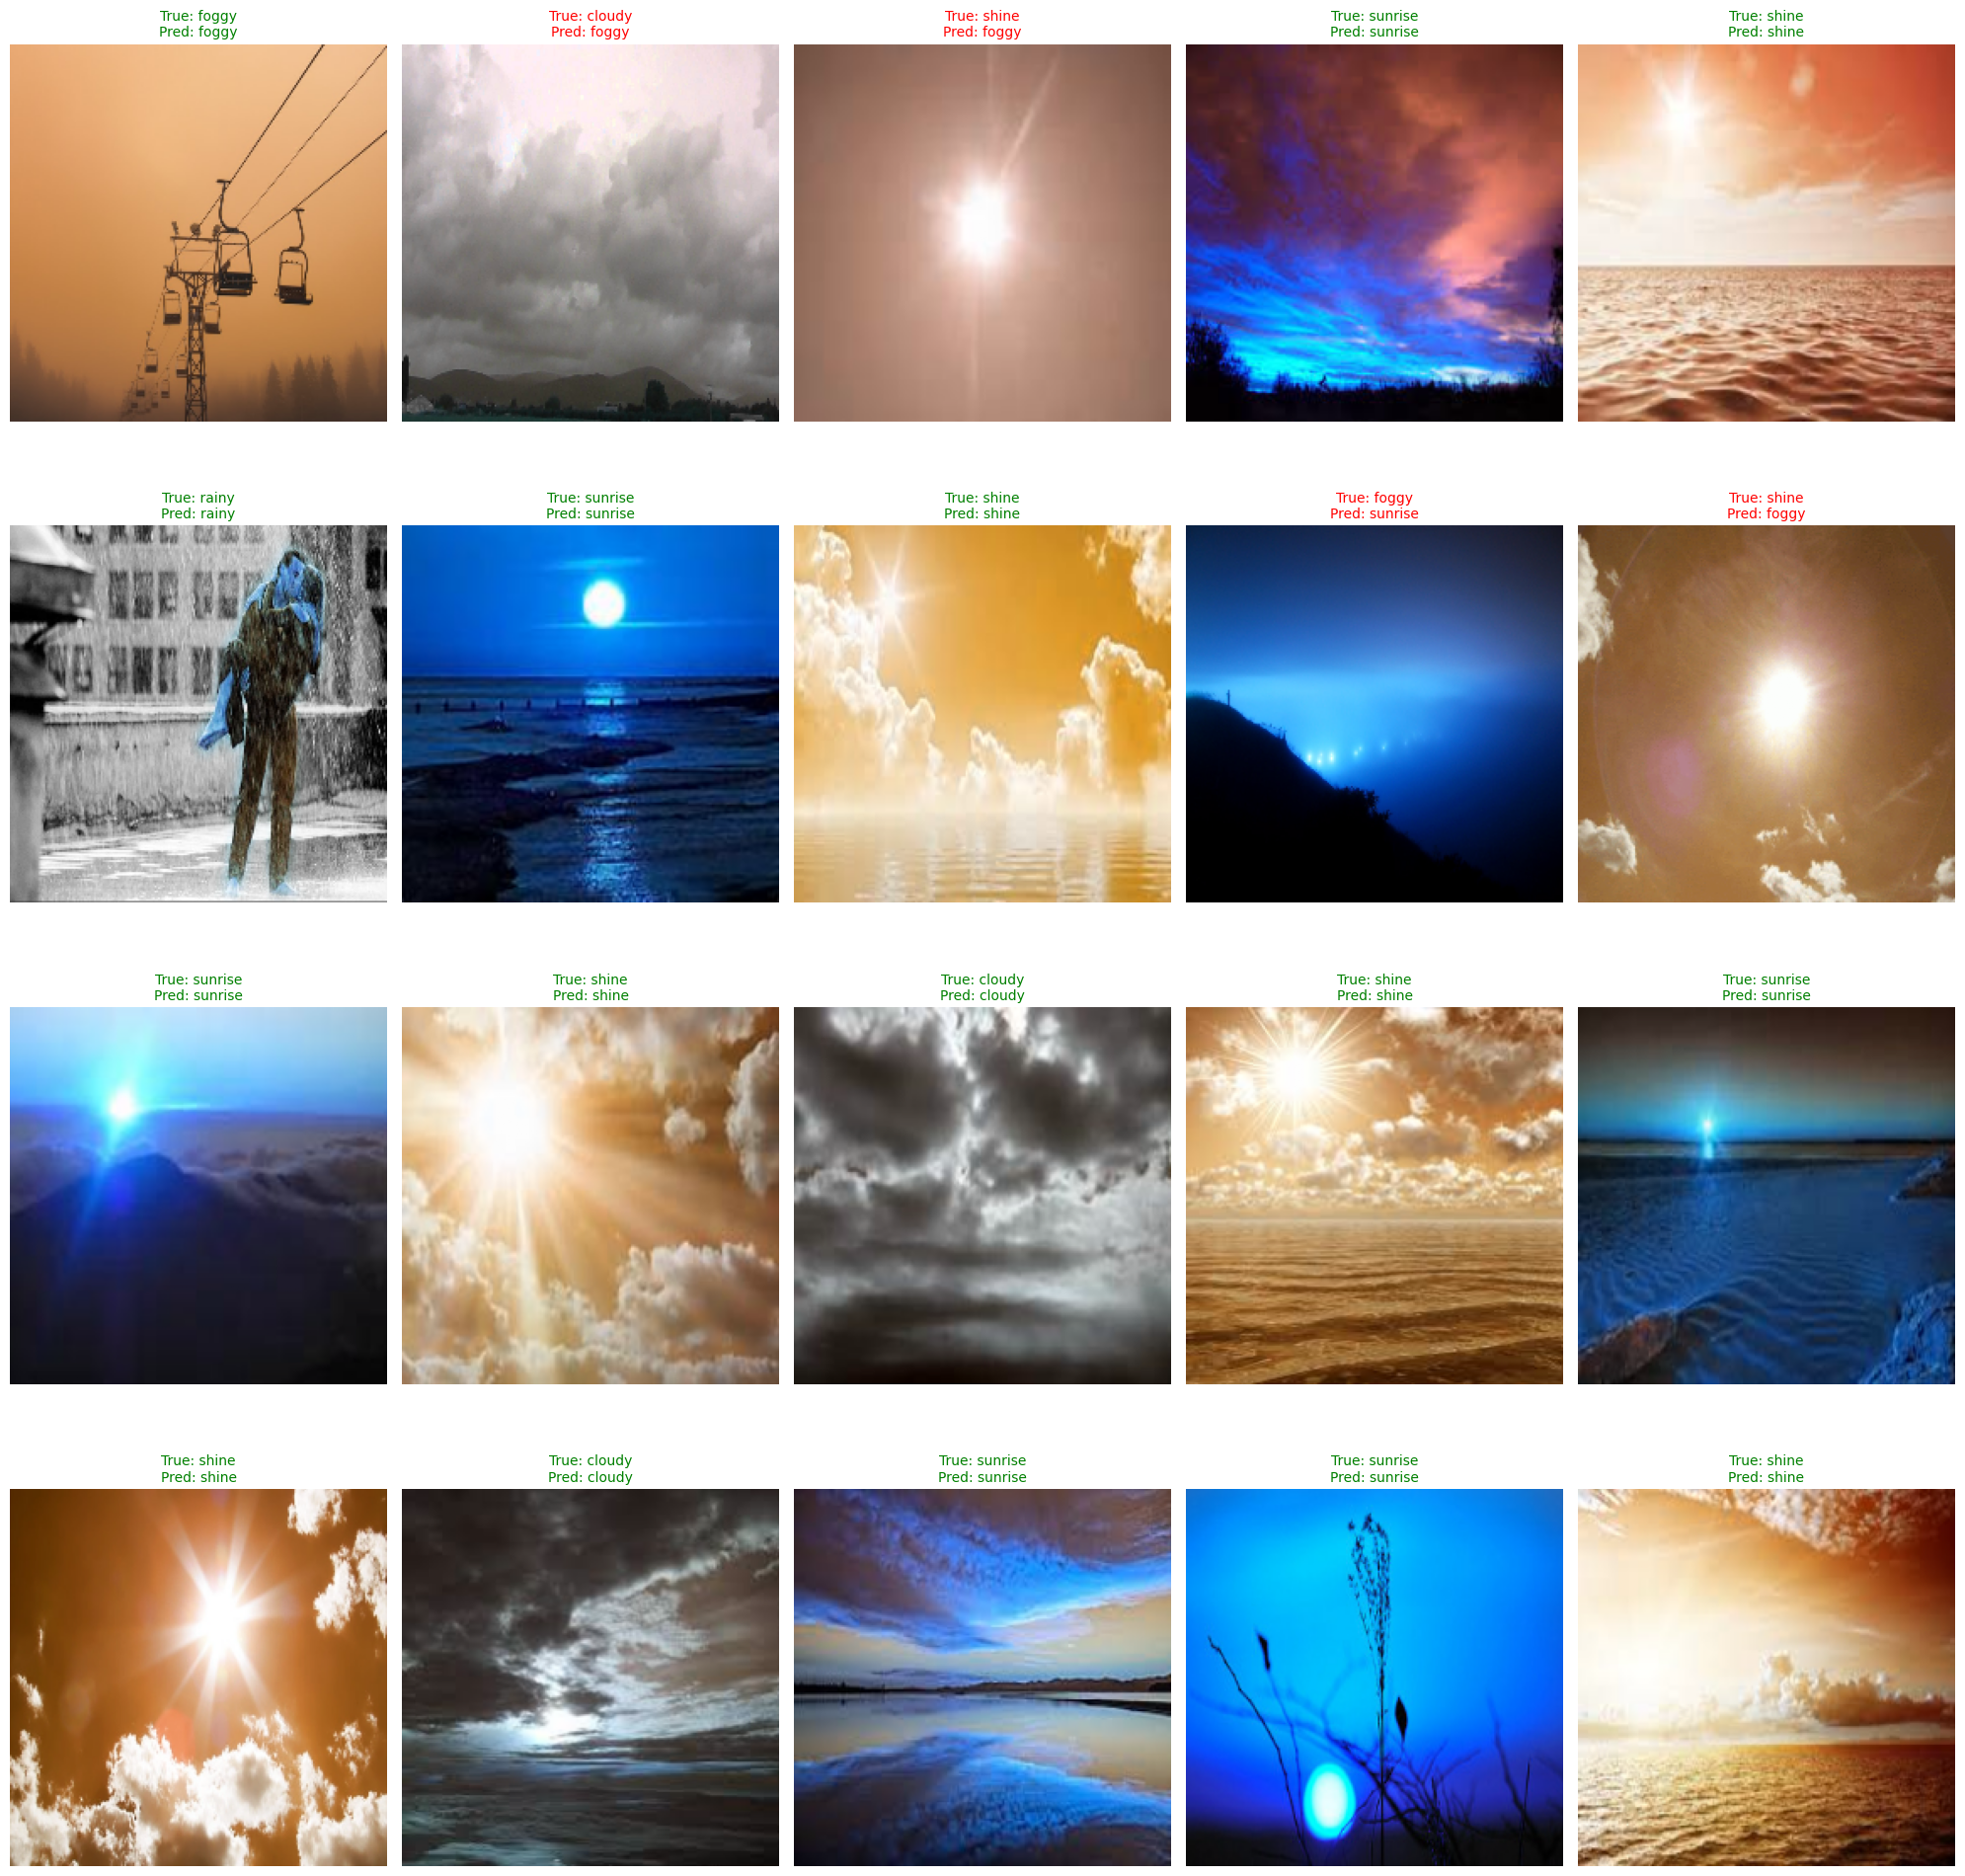

In [ ]:
#  Visualize  correct and incorrect predictions
import random
pred_probs = model.predict(images)
y_pred = np.argmax(pred_probs, axis=1)
y_true = labels


num_samples = 20   
num_wrong = 4      
rows = 4


wrong_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]


random_wrong = random.sample(wrong_indices, num_wrong)


correct_indices = [i for i in range(len(images)) if i not in wrong_indices]
random_correct = random.sample(correct_indices, num_samples - num_wrong)


plot_indices = sorted(random_correct + random_wrong)

# Plot
plt.figure(figsize=(20, 20))
cols = num_samples // rows
for i, idx in enumerate(plot_indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[idx])

    true_class = classes[y_true[idx]]
    pred_class = classes[y_pred[idx]]

    color = 'green' if true_class == pred_class else 'red'
    plt.title(f"True: {true_class}\nPred: {pred_class}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
